# README

In [4]:
README = '''
Julian Smoller ~ 2017.04.21

# Intro:
The purpose of this notebook is to create a Jigsaw puzzle using pixel-like blocks. 

'''
print(README)


Julian Smoller ~ 2017.04.21

# Intro:
The purpose of this notebook is to create a Jigsaw puzzle using pixel-like blocks. 




In [5]:
########################################################################
# Import libraries
import numpy as np
import colorsys
import pandas as pd
from PIL import Image
import pickle

########################################################################
# Change display settings:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
%matplotlib inline

# General functions for matrix manipulation

In [3]:
def rotate(matrix):
    '''Rotate matrix clockwise by 90 degrees'''
    return np.matrix([list(reversed(row)) for row in matrix.T.A])

def equal(matrix1, matrix2):
    '''Check if 2 matrixes are equal in shape and value'''
    if matrix1.shape != matrix2.shape:
        return False
    else:
        for x1,x2 in zip(matrix1.flat,matrix2.flat):
            if x1 != x2:
                return False
        return True

def rotations(matrix):
    '''Generate 4 rotations of a given matrix'''
    rotations = [matrix]
    for i in range(3):
        rotated = rotate(rotations[-1])
        rotations.append(rotated)
    return rotations

def unique(matrix, matrixes):
    '''Determine if a given matrix is similar (rotationally symmetric) 
    to any of the matrixes in a list'''
    for matrix1 in rotations(matrix):
        for matrix2 in matrixes:
            if equal(matrix1,matrix2):
                return False
    return True
 
def in_list(matrix, matrixes):
    '''Determine if a given matrix is equal to any of the matrixes in a list'''
    for matrix2 in matrixes:
        if equal(matrix,matrix2):
            return True
    return False

def similar(matrix1,matrix2):
    '''Check if one matrix is rotationally symmetric to another '''
    return inside(matrix1,rotations(matrix2))

def add_border(matrix):
    '''Add a border of 0's around all 4 sides of a matrix'''
    rows = []
    rows += [[0] * (matrix.shape[1]+2)]
    rows += [[0] + list(row) + [0] for row in matrix.A]
    rows += [[0] * (matrix.shape[1]+2)]
    return np.matrix(rows)

def trim(matrix):
    '''Remove empty rows and columns from a matrix'''
    matrix = np.matrix([r for r in matrix.A if np.any(r)])
    matrix = np.matrix([r for r in matrix.T.A if np.any(r)]).T
    return matrix

def empty_spots(matrix):
    '''Get row/col coordinates of cells in and around a matrix 
    where you could attach a block; you can only attach if new block borders
    one of the existing blocks'''
    expanded_matrix = add_border(matrix) 
    empty_spots = set()
    for r, row in enumerate(matrix.A):
        for c, value in enumerate(row):
            if value==1:
                neighbors = [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]
                empty_neighbors = [n for n in neighbors if expanded_matrix.A[n[0]+1][n[1]+1]==0]
                empty_spots.update(empty_neighbors)
    return empty_spots

def inner_spots(spots,matrix):
    '''Filter set of empty spots for inner spots, 
    i.e. those within bounds of matrix'''
    return [s for s in spots if s[0]>=0 and s[0]<matrix.shape[0] and s[1]>=0 and s[1]<matrix.shape[1]]

def sum_spots(spots,matrix):
    '''Get sum of values in given locations'''
    total = 0
    for spot in spots:
        total += matrix.A[spot[0]][spot[1]]
    return total

def add_one(matrix):
    '''Generate a new set of matrixes with an additional 
    1 inside or outside an existing matrix'''
    bigger_matrixes = []
    expanded_matrix = add_border(matrix)
    for spot in empty_spots(matrix):
        new_matrix = expanded_matrix.copy()
        new_matrix.A[spot[0]+1][spot[1]+1] = 1
        new_matrix = trim(new_matrix)
        if unique(new_matrix, bigger_matrixes):
            bigger_matrixes.append(new_matrix)
    return bigger_matrixes

def add_one_to_each(matrixes):
    '''Generate a new set of matrixes by adding 1 to each matrix in existing set'''
    bigger_matrixes = []
    for matrix in matrixes:
        for new_matrix in add_one(matrix):
            if unique(new_matrix, bigger_matrixes):
                bigger_matrixes.append(new_matrix)
    return bigger_matrixes

def make_shapes(n=3):
    '''Generate all unique shapes of size n blocks (or smaller)'''
    shapes = [[np.matrix([[1]])]]
    if n<10: # emergency cutoff
        for i in range(2,n+1):
            print('Creating shapes of size',i)
            shapes.append(add_one_to_each(shapes[-1])) 
    return shapes

def flatten(lst):
    '''Flatten a list of lists (2d >> 1d)'''
    return [item for sublist in lst for item in sublist]

def permute(matrix):
    '''Rotate a matrix to create all unique permutations 
    (e.g. 2 out of 4 for a line of 1)'''
    m0 = matrix
    m1 = rotate(m0)
    m2 = rotate(m1)
    m3 = rotate(m2)
    permutations = [m0]
    for m in [m1,m2,m3]:
        if not in_list(m,permutations): # if not already in set
            permutations.append(m)
    return permutations

def nonzero_cells(matrix):
    '''Get (r,c) coordinates for all non-zero cells'''
    cells = []
    for r in range(matrix.shape[0]):
        for c in range(matrix.shape[1]):
            if matrix.A[r][c]!=0:
                cells.append((r,c))
    return cells

def zero_cells(matrix):
    '''Get (r,c) coordinates for all zero cells'''
    cells = []
    for r in range(matrix.shape[0]):
        for c in range(matrix.shape[1]):
            if matrix.A[r][c]==0:
                cells.append((r,c))
    return cells

def both_dimensions_smaller(m1,m2):
    '''Check if r and c dimensions of first matrix 
    are both within bounds of second matrix'''
    return m1.shape[0]<=m2.shape[0] and m1.shape[1]<=m2.shape[1]

# Special functions for Jigsaw matrix manipulation

In [14]:
def order_cells_by_distance_to_center(matrix):
    return order_cells_by_distance(all_cells(matrix),center_cell(matrix))
def all_cells(matrix):
    return [(r,c) for r in range(matrix.shape[0]) for c in range(matrix.shape[1])]
def order_cells_by_distance(cells,cell):
    return [x[1] for x in sorted([(distance_between_cells(c,cell),c) for c in cells])]
def center_cell(matrix):
    return (matrix.shape[0]/2,matrix.shape[1]/2)
def distance_between_cells(cell1,cell2):
    return max([abs(cell1[0]-cell2[0]), abs(cell1[1]-cell2[1])])
def cell_neighbors(cell):
    return [(cell[0]+1,cell[1]),(cell[0]-1,cell[1]),(cell[0],cell[1]+1),(cell[0],cell[1]-1)]

# Jigsaw classes: Shape and Puzzle

In [15]:
class Shape:
    '''A Shape is a set of contiguous blocks, represented by a matrix'''
    def __init__(self,matrix):
        self.matrix = matrix
        self.size = self.matrix.sum()
        self.permutations = permute(self.matrix)
        self.label = None
        self.permutation_cells = [nonzero_cells(m) for m in self.permutations]
    def describe(self):
        print('Size:',self.size)
        print('Label:', self.label)
        print('Permutations:', len(self.permutations))
        for i,m in enumerate(self.permutations):
            print('-'*20)
            print(m)
            print('Cells:', self.permutation_cells[i])
            
class Puzzle:
    '''A Puzzle is a collection of shapes'''
    def __init__(self,x,y):
        self.matrix = np.matrix([[0]*x for i in range(y)])
        self.labels = np.matrix([[0]*x for i in range(y)])
        self.colors = np.matrix([[0]*x for i in range(y)])
        self.pieces = [] # shapes actually placed into puzzle
        self.shapes = None # possible shapes that can be used as peices
        #self.spiral_cells = order_cells_by_distance_to_center(self.matrix)
        self.spiral_cells = order_cells_by_distance(all_cells(self.matrix),(10,8))
        # Compile matrix after each shape is added
        self.steps = []
    def fill(self,shapes, cycles=100):
        self.populate(shapes)
        cycle = 0
        while np.count_nonzero(self.matrix)<self.matrix.size and cycle<cycles:
            cycle += 1
            print('='*20,'Cycle:',cycle)
            print('Filled', np.count_nonzero(self.matrix), 'of',self.matrix.size,'matrix cells')
            print('Placed',len(self.pieces),'peices using',sum(self.shapes['count']>0),'of',len(shapes),'shapes')
            print('Shapes left to try:',sum(self.shapes['try']))
            print('='*40)
            for i in self.shapes_to_try(cycle).index:
                if self.pack(self.shapes.ix[i,'shape']): # try to pack
                    self.pieces.append(i)
                    self.shapes.ix[i,'count'] += 1 # if yes, increment the count for this shape
                    self.shapes.ix[i,'pieces'].append(len(self.pieces)) # if yes, store piece ID with shape
                    self.steps.append(self.matrix.copy())
                else:
                    self.shapes.ix[i,'try'] = False # if no, set flag to False so we don't try again
    def shapes_to_try(self,cycle):
        if cycle==1:
            return self.shapes
        else:
            # start with largest shape that you can still try
            return self.shapes[self.shapes['try']].sort_values('size',ascending=False) 
    def populate(self,shapes):
        shape_data = [(s,s.size,0,True,[]) for s in shapes]
        self.shapes = pd.DataFrame(shape_data, columns=['shape','size','count','try','pieces'])
    def pack(self,shape):
        place = self.best_place(shape)
        if place is None:
            #print 'Error: shape of size',shape.size,'does not fit'
            return False
        else:
            self.put(shape,place)
            #print 'Added',shape.size,'block shape to',place['placement_cell'],': filled',place['score'],'border cells'
            return True
    def put(self,shape,place):
        shape_cells = shape.permutation_cells[place['permutation']]
        shifted_cells = self.shift(shape_cells,place['placement_cell'])
        for cell in shifted_cells:
            self.matrix.A[cell[0]][cell[1]] = 1
            self.labels.A[cell[0]][cell[1]] = len(self.pieces)
    def best_place(self,shape):
        places = self.possible_places(shape)
        if len(places)==0:
            return None
        else:
            return places.iloc[0] if len(self.pieces)==0 else places.sort_values('score',ascending=False).iloc[0]
    def possible_places(self,shape):
        places = {'placement_cell':[],'permutation':[],'score':[]}
        border_cells = inner_spots(empty_spots(self.matrix),self.matrix)
        for placement_cell in self.spiral_cells: # starting with the center cell, spiral out until the shape fits
            for p, shape_cells in enumerate(shape.permutation_cells): # try each permutation
                shifted_cells = self.shift(shape_cells,placement_cell)
                if self.fits(shifted_cells): # if the shape is within bounds and doesn't overlap
                    score = len([c for c in shifted_cells if c in border_cells])
                    places['placement_cell'].append(placement_cell)
                    places['permutation'].append(p)
                    places['score'].append(score)               
        return pd.DataFrame(places)
    def fits(self,cells): 
        for cell in cells:
            if not (self.contains(cell) and self.get(cell)==0):
                return False
        return True
    def shift(self,cells,delta): # shift the coordinates of each cell by r/c
        return [(cell[0]+delta[0],cell[1]+delta[1]) for cell in cells]
    def contains(self,cell): 
        return cell[0]>=0 and cell[0]<self.matrix.shape[0] and cell[1]>=0 and cell[1]<self.matrix.shape[1]
    def get(self,cell):
        return self.matrix.A[cell[0]][cell[1]]

# General image functions

In [20]:
# Get n unique colors
def get_n_colors(n=5):
    hsv_tuples = [(x*1.0/n, 0.5, 1) for x in range(n)]
    rgb_tuples = [tuple(map(lambda x: int(x*255),colorsys.hsv_to_rgb(*hsv))) for hsv in hsv_tuples]
    return rgb_tuples
def assign_colors(values):
    color_code = {}
    color_code[0] = (0,0,0)
    values = [v for v in values if v!=0]
    colors = get_n_colors(len(values))
    for v,c in zip(values,colors):
        color_code[v]=c
    return color_code
def draw(matrix, scale=10):
    values = np.unique(matrix.flat)
    color_code = assign_colors(values)
    width = matrix.shape[1]*scale
    height = matrix.shape[0]*scale
    image = Image.new('RGB',(width,height),(0,0,0))
    for r in range(matrix.shape[0]):
        for c in range(matrix.shape[1]):
            value = matrix.A[r][c]
            color = color_code[value]
            block = Image.new('RGB',(scale,scale),color)
            box = (c*scale,r*scale,c*scale+scale,r*scale+scale)
            image.paste(block,box)
    return image

# Generate shapes

In [17]:
# Generate shapes
shapes2d = make_shapes(n=6)
shapes1d = flatten(shapes2d)
print(len(shapes1d), 'shapes total')
shapes = [Shape(s) for s in shapes1d]

Creating shapes of size 2
Creating shapes of size 3
Creating shapes of size 4
Creating shapes of size 5
Creating shapes of size 6
89 shapes total


# Pack shapes into puzzle

In [18]:
# Pack shapes into puzzle
pz = Puzzle(25,25)
pz.fill(shapes, cycles=40)

==================== Cycle: 1
Filled 0 of 625 matrix cells
Placed 0 peices using 0 of 89 shapes
Shapes left to try: 89
==================== Cycle: 2
Filled 487 of 625 matrix cells
Placed 89 peices using 89 of 89 shapes
Shapes left to try: 89
==================== Cycle: 3
Filled 589 of 625 matrix cells
Placed 109 peices using 89 of 89 shapes
Shapes left to try: 20
==================== Cycle: 4
Filled 598 of 625 matrix cells
Placed 113 peices using 89 of 89 shapes
Shapes left to try: 4
==================== Cycle: 5
Filled 601 of 625 matrix cells
Placed 115 peices using 89 of 89 shapes
Shapes left to try: 2
==================== Cycle: 6
Filled 604 of 625 matrix cells
Placed 117 peices using 89 of 89 shapes
Shapes left to try: 2
==================== Cycle: 7
Filled 607 of 625 matrix cells
Placed 119 peices using 89 of 89 shapes
Shapes left to try: 2
==================== Cycle: 8
Filled 610 of 625 matrix cells
Placed 121 peices using 89 of 89 shapes
Shapes left to try: 2
===================

# Save packed puzzle

In [25]:
pickle.dump(pz.steps, open('data/output/puzzle_packing.p','wb'))

# Draw shapes within puzzle

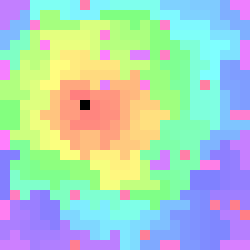

In [21]:
draw(pz.labels)

# Analyze puzzle/shape data

In [24]:
print(len(pz.pieces), len(shapes), len(pz.steps))
pz.shapes.sort_values('count',ascending=False).head(10)

135 89 135


,shape,size,count,try,pieces
0,<__main__.Shape object at 0x7f46055d6320>,1,20,True,"[1, 109, 113, 115, 117, 119, 121, 123, 124, 12..."
1,<__main__.Shape object at 0x7f46055d6358>,2,8,False,"[2, 108, 112, 114, 116, 118, 120, 122]"
2,<__main__.Shape object at 0x7f46055d6668>,3,3,False,"[3, 106, 111]"
3,<__main__.Shape object at 0x7f46055d6128>,3,3,False,"[4, 107, 110]"
66,<__main__.Shape object at 0x7f4605336240>,6,2,False,"[67, 102]"
65,<__main__.Shape object at 0x7f4605336748>,6,2,False,"[66, 92]"
64,<__main__.Shape object at 0x7f4605336b70>,6,2,False,"[65, 93]"
63,<__main__.Shape object at 0x7f46053365f8>,6,2,False,"[64, 94]"
40,<__main__.Shape object at 0x7f46053364a8>,6,2,False,"[41, 103]"
61,<__main__.Shape object at 0x7f4605336470>,6,2,False,"[62, 96]"


# Draw value counts for each shape

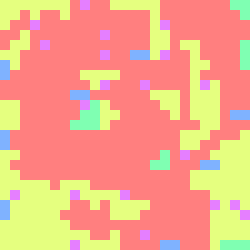

In [26]:
# Draw value counts for each shape / piece
matrix = []
for r in range(pz.labels.A.shape[0]):
    row = []
    for c in range(pz.labels.A.shape[1]):
        label = pz.labels.A[r][c]
        shape_id = pz.pieces[label]
        count = pz.shapes.ix[shape_id,'count']
        row.append(count)
    matrix.append(row)
draw(np.matrix(matrix))

# Recolor puzzle with ~4 colors

In [28]:
class Recolorer:
    def recolor(self,matrix):
        self.colors = [1,2,3,4]
        self.matrix = matrix
        self.neighbors = self.neighbor_network(self.matrix)
        self.df = self.neighbor_df(self.neighbors)
        print('Unique values:',len(self.df))
        self.assign_colors()
        unassigned = self.unassigned()
        print('Unassigned:',len(unassigned))
        print('Attempting to reassign...')
        for i in unassigned:
            self.reassign(i)
        unassigned = self.unassigned()
        print('Still unassigned:',len(unassigned))
        return self.render()
    def render(self):
        matrix = self.matrix.copy()
        for r in range(matrix.shape[0]):
            for c in range(matrix.shape[1]):
                value = matrix.A[r][c]
                matrix.A[r][c] = self.df.ix[value,'color']
        return matrix
    def assign_colors(self):
        for i in self.df.index:
            self.assign(i)
    def assign(self,i):
        colors = self.possible_colors(i)
        if len(colors)>0:
            self.df.ix[i,'color'] = colors[0]
    def unassigned(self):
        return self.df[self.df['color'].map(lambda x: x not in self.colors)].index
    def reassign(self,i):
        df = self.neighbor_data(i)
        colors = df.groupby('color').agg({'switchable':np.all}) # are all neighbors of a given color switchable?
        options = colors[colors['switchable']].index
        if len(options)>0:
            new_color = options[0]
            self.df.ix[i,'color'] = new_color
            neighbors_to_reassign = list(df[df['color']==new_color]['n'])
            for n in neighbors_to_reassign:
                self.assign(n)
    def neighbor_data(self,i):
        d = {'n':[],'color':[],'new_colors':[],'switchable':[]}
        for n in self.neighbors[i]:
            new_colors = self.possible_colors(n)
            d['n'].append(n)
            d['color'].append(self.df.ix[n,'color'])
            d['new_colors'].append(new_colors)
            d['switchable'].append(len(new_colors)>0)
        return pd.DataFrame(d)
    def neighbor_network(self,matrix):
        values = np.unique(matrix.flat)
        network = {x:set() for x in values}
        for r in range(matrix.shape[0]):
            for c in range(matrix.shape[1]):
                value = matrix.A[r][c]
                neighbors = [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]
                for n in neighbors:
                    if 0<=n[0]<matrix.shape[0] and 0<=n[1]<matrix.shape[1]: # cell in bounds
                        neighbor_value = matrix.A[n[0]][n[1]] 
                        if neighbor_value != value:
                            network[value].add(neighbor_value)
        return network
    def neighbor_df(self,network):
        df = pd.DataFrame({'value':[x for x in network]})
        df['neighbors'] = df['value'].map(lambda x: network[x])
        df['color'] = [None for i in df.index]
        df = df.set_index('value',drop=True)
        return df
    def neighbor_colors(self,i):
        return set([self.df.ix[n,'color'] for n in self.neighbors[i]])
    def possible_colors(self,i):
        return [c for c in self.colors if c not in self.neighbor_colors(i)]

Unique values: 135
Unassigned: 2
Attempting to reassign...
Still unassigned: 0


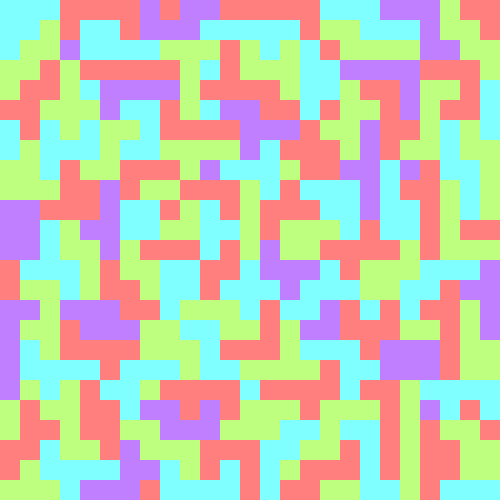

In [30]:
r = Recolorer()
puzzle_colored = draw(r.recolor(pz.labels),scale=20)
puzzle_colored

# Save colored puzzle

In [33]:
puzzle_colored.save('data/output/puzzle_colored.png')

# Painting class: Construct block painting from dataframe

In [49]:
class Painting:
    def __init__(self,x=10,offset=(0,0),inner_colors=[]):
        self.x = x
        self.canvas = pd.DataFrame(np.matrix([['']*x for i in range(x)]))
        self.cells = [(r,c) for r in range(self.canvas.shape[0]) for c in range(self.canvas.shape[1])]
        self.mid = int(x/2)
        self.center = (self.mid,self.mid)
        self.heart_center = (self.mid+offset[0],self.mid+offset[1])
        self.colors = self.get_colors(inner_colors)
        self.heart = self.heart_cells()
        self.cross = self.cross_cells()
        self.inner = self.inner_heart_cells()
        self.outer = self.outer_heart_cells()
        self.zones = self.zone_cells()
        self.draw()
    def hsv_to_rgb(self,hsv):
        return tuple(map(lambda x: int(x*255),colorsys.hsv_to_rgb(*hsv)))
    def get_colors(self,inner_colors):
        colors = {}
        colors['z0'] = (85,200,200) # zones 2,4,6,8
        colors['z1'] = (28,122,205) # zones 1,3,5,7
        colors['h'] = (0,0,0) # heart perimeter
        colors['x'] = (0,0,0) # cross
        for i,color in enumerate(inner_colors):
            code = 'h'+str(i)
            colors[code] = color  
        return colors
    def heart_cells(self):
        left = []
        left += [(5,11),(5,10),(5,9),(4,9),(4,8),(4,7),(4,6),(4,5),(4,4),(5,4),(5,3),(6,3),(6,2)]
        left += [(7,2),(7,1),(8,1),(9,1),(10,1),(11,1),(12,1),(13,1),(13,2),(14,2),(14,3),(15,3),(15,4)]
        left += [(16,4),(16,5),(17,5),(17,6),(18,6),(18,7),(19,7),(19,8),(19,9),(20,9),(20,10),(20,11),(21,11)]
        right = []
        for cell in left:
            right += [(cell[0],self.canvas.shape[1]-cell[1]-1)]
        heart_cells = right+left+[(5,12),(21,12)] # add cells in middle column
        return heart_cells
    def inside_heart(self,cell): # determine if given cell is inside boundary of heart
        h_cells = [h for h in self.heart if h[1]==cell[1]] # heart cells with same column
        if len(h_cells)>0:
            min_row = min([h[0] for h in h_cells])
            max_row = max([h[0] for h in h_cells])
            return cell not in h_cells and cell[0]>min_row and cell[0]<max_row
        return False
    def cross_cells(self):
        cross_cells = []
        for (r,c) in self.cells:
            if r==self.mid or c==self.mid or r==c or r+c==self.mid*2:
                if not self.inside_heart((r,c)):
                    cross_cells += [(r,c)]
        return cross_cells
    def inner_heart_cells(self):
        return [c for c in self.cells if self.inside_heart(c)]
    def outer_heart_cells(self):
        return [c for c in self.cells if c not in self.heart+self.cross+self.inner]
    def zone_cells(self):
        zone = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]} # clockwise
        for cell in self.outer:
            r,c = cell
            if r<self.mid: # upper half
                if c<self.mid: # upper left
                    if r>c:
                        zone[7].append(cell)
                    else:
                        zone[8].append(cell)
                else: # upper right
                    if (self.mid*2-r)>c:
                        zone[1].append(cell)
                    else:
                        zone[2].append(cell)
            else: # lower half
                if c<self.mid: # lower left
                    if (self.mid*2-r)>c:
                        zone[6].append(cell)
                    else:
                        zone[5].append(cell)
                else: # lower right
                    if r>c:
                        zone[4].append(cell)
                    else:
                        zone[3].append(cell)
        return zone
    def distance(self,cell1,cell2):
        return abs(cell1[0]-cell2[0]) + abs(cell1[1]-cell2[1])   
    def draw(self):
        for cell in self.heart:
            self.draw_cell(cell,'h')
        for cell in self.cross:
            self.draw_cell(cell,'x')
        for cell in self.inner:
            code = 'h'+str(int(self.distance(cell,self.heart_center)))
            self.draw_cell(cell,code)
        for z in self.zones:
            for cell in self.zones[z]:
                code = 'z'+str(z%2)
                self.draw_cell(cell,code)
    # Populate canvas with color codes
    def draw_cell(self,cell,code):
        self.canvas.ix[cell[0],cell[1]]=code
    def paint(self, scale=10):
        xy = (self.canvas.shape[1]*scale,self.canvas.shape[0]*scale)
        image = Image.new('RGB',xy,(255,255,255))
        for r in range(self.canvas.shape[0]):
            for c in range(self.canvas.shape[1]):
                code = self.canvas.ix[r,c]
                color = self.colors.get(code,(0,0,0))
                block = Image.new('RGB',(scale,scale),color)
                box = (c*scale,r*scale,c*scale+scale,r*scale+scale)
                image.paste(block,box)
        return image

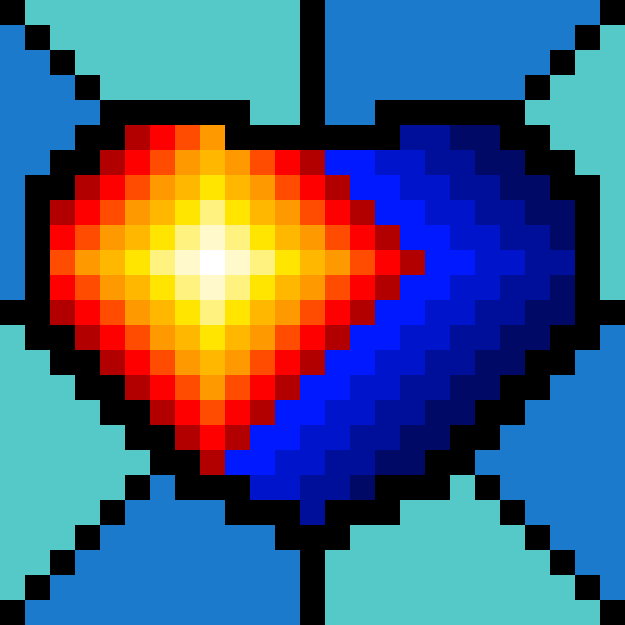

In [52]:
# Color scheme 1
inner_colors = []
inner_colors += [(0,0,1)] # white
inner_colors += [(0.15,0.2,1)] # vanilla
inner_colors += [(0.15,0.5,1)] # yellow1
inner_colors += [(0.15,1,1)] # yellow2
inner_colors += [(0.12,1,1)] # orange1
inner_colors += [(0.10,1,1)] # orange2
inner_colors += [(0.05,1,1)] # orange3
inner_colors += [(0,1,1)] # red
inner_colors += [(0,1,0.7)] # burgundy
inner_colors += [(0.65,1,1)] # blue1
inner_colors += [(0.65,1,1)] # blue1
inner_colors += [(0.65,1,0.8)] # blue2
inner_colors += [(0.65,1,0.8)] # blue2
inner_colors += [(0.65,1,0.6)] # blue3
inner_colors += [(0.65,1,0.6)] # blue3
inner_colors += [(0.65,1,0.4)] # blue4
inner_colors += [(0.65,1,0.4)] # blue4
inner_colors += [(0.65,1,0.2)] # blue5
# Translate to RGB
inner_colors = [tuple(map(lambda x: int(x*255),colorsys.hsv_to_rgb(*hsv))) for hsv in inner_colors]


pt = Painting(x=25,offset=(-2,-4),inner_colors=inner_colors)
pt.paint(scale=25)